In [215]:
import pandas as pd
from scipy.misc import imread,imresize
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
from sklearn.metrics import accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn_extensions.extreme_learning_machines.elm import ELMClassifier,GenELMClassifier,MLPRandomLayer,GenELMRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Convolution2D,MaxPooling2D,Dropout,Activation,BatchNormalization,ZeroPadding2D,Input,Lambda
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD,Adam, nadam
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.models import Model
from keras import regularizers
import keras.backend as K
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print(tf.__version__)

1.1.0


In [53]:
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = '#eeeeee'

In [3]:
train_root='D:/Dataset/New Folder (2)/train'
validation_root='D:/Dataset/New Folder (2)/test/test'

In [4]:
text=open(os.path.join(train_root,'train.txt'))    
lines=text.read()  
train_images=[]
for i in range(1,2289):
    image_name=lines.split('\\')[i].split('\nClass')[0]
    train_images.append(image_name)
train_images[2287]='R_90Class44 (8).jpg'    

In [5]:
text=open(os.path.join(train_root,'val.txt'))    
lines=text.read()  
test_images=[]
for i in range(1,529):
    image_name=lines.split('\\')[i].split('\nClass')[0]
    test_images.append(image_name)
test_images[527]='R_45Class44 (3).jpg'    

In [230]:
train_array=[]
for i in range(1,45): 
    image_class=os.path.join(train_root,str('Class ('+str(i)+')'))
    for image in train_images[(i-1)*52:(i-1)*52+52]:
        img_path=os.path.join(image_class,image)
        img=imread(img_path)
        img=imresize(img,(256,256))
        #tupl=(i,img)
        train_array.append(img)
train_array=np.array(train_array)
train_array=train_array/255

In [7]:
index_shuffle=np.arange(2288)
np.random.shuffle(index_shuffle)
train_array=train_array[index_shuffle]

In [229]:
test_array=[]
for i in range(1,45): 
    image_class=os.path.join(validation_root,str('Class ('+str(i)+')'))
    for image in test_images[(i-1)*12:(i-1)*12+12]:
        img_path=os.path.join(image_class,image)
        img=imread(img_path)
        img=imresize(img,(256,256))
        #tupl=(i,img)
        test_array.append(img)
test_array=np.array(test_array)
test_array=test_array/255

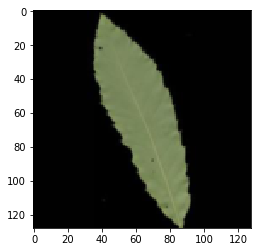

In [9]:
plt.imshow(test_array[0])


In [15]:
y_train=[]
for i in range(1,45):
    for j in range(52):
        y_train.append(i)
y_train=np.array(y_train)
y_train=y_train[index_shuffle]
y_test=[]
for i in range(1,45):
    for j in range(12):
        y_test.append(i)
y_train_label=y_train
y_test_label=y_test
y_train=pd.get_dummies(y_train,prefix='class')
y_test=pd.get_dummies(y_test,prefix='class')        

In [16]:
X=np.concatenate([train_array,test_array],axis=0)
y=pd.concat([y_train,y_test],axis=0)
print (X.shape)
print (y.shape)

(2816, 128, 128, 3)
(2816, 44)


# Model Building

In [232]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(128,128,3)))
model.add(Convolution2D(16, kernel_size=(3, 3), strides=(1, 1) #stride changed from (2,2 ) to (1,1)
                 ))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(32, (5, 5),strides=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3),strides=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(1024))
# model.add(BatchNormalization()) #adding batch normalization added accuracy
# model.add(Activation('relu'))
model.add(Dense(256)) # an extra layer added increased accuracy ,then batch norm was ot included in the model
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(256)) # an extra layer added increased accuracy ,then batch norm was ot included in the model
model.add(Dropout(.4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(44))
#model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_10 (ZeroPaddi (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
activation_31 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 66, 66, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 62, 32)        12832     
__________

In [181]:
adam=Adam(lr=.0001,beta_2=0.99,decay=1e-5)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(train_array,y_train,epochs=20,validation_data=(test_array,y_test),batch_size=20, verbose= 1)

Train on 2288 samples, validate on 528 samples
Epoch 1/15
2288/2288 [==============================] - 234s 102ms/step - loss: 3.6240 - acc: 0.0656 - val_loss: 4.3634 - val_acc: 0.0227
Epoch 2/15
2288/2288 [==============================] - 238s 104ms/step - loss: 2.8563 - acc: 0.2085 - val_loss: 5.7399 - val_acc: 0.0436
Epoch 3/15
2288/2288 [==============================] - 253s 111ms/step - loss: 2.2202 - acc: 0.3623 - val_loss: 6.3042 - val_acc: 0.0549
Epoch 4/15
2288/2288 [==============================] - 217s 95ms/step - loss: 1.7559 - acc: 0.4943 - val_loss: 6.1802 - val_acc: 0.0625
Epoch 5/15
2288/2288 [==============================] - 230s 100ms/step - loss: 1.4229 - acc: 0.5957 - val_loss: 4.6380 - val_acc: 0.0890
Epoch 6/15
2288/2288 [==============================] - 232s 101ms/step - loss: 1.1974 - acc: 0.6534 - val_loss: 2.2161 - val_acc: 0.3333
Epoch 7/15
2288/2288 [==============================] - 243s 106ms/step - loss: 0.9540 - acc: 0.7395 - val_loss: 2.1249 - val_

This is the first basic model and as we can see the model is overfitting heavily,and now when we are able to get approx 65% validation accuracy ,we will try to improve it from here on.
                         We will use ELM to classify the classes

In [183]:
weights='model_weights.hdf'
model.save_weights(weights)
#model.load_weights('model_weights.hdf')

In [51]:
#y_pred_train=model.predict(train_array)
# log_loss(y_pred_train,y_train)
# y_labels=1+np.argmax(y_pred_train,axis=1)

In [176]:
#model_new=model
# model_new.layers.pop()
# model_new.layers.pop()
# model_new.layers.pop()
# model_new.layers.pop()
# model_new.layers.pop()
# model_new.layers.pop()
# model_new.summary()
train_features=model_new.predict(train_array)
test_features=model_new.predict(test_array)

In [98]:
model2 = Sequential()
model2.add(ZeroPadding2D((1,1),input_shape=(128,128,3)))
model2.add(Convolution2D(16, kernel_size=(3, 3), strides=(1, 1) #stride changed from (2,2 ) to (1,1)
                 ))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(ZeroPadding2D((1,1)))
model2.add(Convolution2D(32, (5, 5),strides=(1,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(ZeroPadding2D((1,1)))
model2.add(Convolution2D(64, (3, 3),strides=(1,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

convout1=MaxPooling2D(pool_size=(2, 2))
model2.add(convout1)

model2.add(Flatten())
# model2.add(Dense(1024))
# model2.add(BatchNormalization()) #adding batch normalization added accuracy
# model2.add(Activation('relu'))
denseout=Dense(256)
model2.add(denseout) # an extra layer added increased accuracy ,then batch norm was ot included in the model
model2.add(Dropout(.5))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(Dense(256)) # an extra layer added increased accuracy ,then batch norm was ot included in the model
model2.add(Dropout(.5))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(Dense(44))
#model2.add(BatchNormalization())
model2.add(Activation('softmax'))

# model2.load_weights(weights)
# callback=ModelCheckpoint('weights_model2.hdf5',monitor='val_acc',save_best_only=True,save_weights_only=True)
# adam=Adam(lr=.0001,beta_2=0.99,decay=1e-4)
# model2.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
# history2=model2.fit(train_array,y_train,epochs=20,validation_data=(test_array,y_test),batch_size=20, verbose= 1,callbacks=[callback])

In [99]:
model2.load_weights('weights_model2.hdf5')

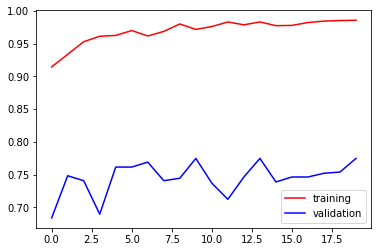

In [301]:
plt.plot(history2.history['acc'],color='r',label='training')
plt.plot(history2.history['val_acc'],color='b',label='validation')
plt.legend(loc='best')

In [28]:
pred=model2.predict(test_array)
pred_label=np.argmax(pred,axis=1)+1
accuracy_score(pred_label,y_test_label)

0.77462121212121215

In [302]:
ndam=nadam(lr=.000001)
model2.compile(loss='categorical_crossentropy',optimizer=ndam,metrics=['accuracy'])
history2_new=model2.fit(train_array,y_train,epochs=20,validation_data=(test_array,y_test),batch_size=20, verbose= 1,callbacks=[callback])

Train on 2288 samples, validate on 528 samples
Epoch 1/20
2288/2288 [==============================] - 206s 90ms/step - loss: 0.0955 - acc: 0.9830 - val_loss: 0.9996 - val_acc: 0.7178
Epoch 2/20
2288/2288 [==============================] - 203s 89ms/step - loss: 0.0917 - acc: 0.9847 - val_loss: 0.8684 - val_acc: 0.7689
Epoch 3/20
2288/2288 [==============================] - 202s 88ms/step - loss: 0.0845 - acc: 0.9873 - val_loss: 0.8514 - val_acc: 0.7689
Epoch 4/20
2288/2288 [==============================] - 202s 88ms/step - loss: 0.0784 - acc: 0.9865 - val_loss: 0.9067 - val_acc: 0.7481
Epoch 5/20
2288/2288 [==============================] - 1717s 750ms/step - loss: 0.0768 - acc: 0.9856 - val_loss: 0.8690 - val_acc: 0.7614
Epoch 6/20
2288/2288 [==============================] - 272s 119ms/step - loss: 0.0806 - acc: 0.9860 - val_loss: 0.8719 - val_acc: 0.7595
Epoch 7/20
2288/2288 [==============================] - 249s 109ms/step - loss: 0.0709 - acc: 0.9886 - val_loss: 0.8730 - val_ac

KeyboardInterrupt: 

In [ ]:
# plt.plot(history2_new.history['acc'],color='r',label='training')
# plt.plot(history2_new.history['val_acc'],color='b',label='validation')
# plt.legend(loc='best')

In [103]:
# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model2.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [30]:
test_features=convout1_f(test_array)
train_features1=convout1_f(train_array[0:500])
train_features2=convout1_f(train_array[500:1000])
train_features3=convout1_f(train_array[1000:1500])
train_features4=convout1_f(train_array[1500:2000])
train_features5=convout1_f(train_array[2000:])
train_features=np.concatenate([train_features1[0],train_features2[0],train_features3[0],train_features4[0],train_features5[0]],axis=0)
train_features.shape

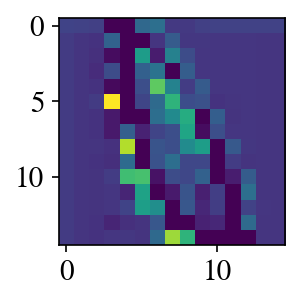

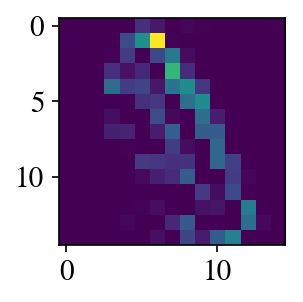

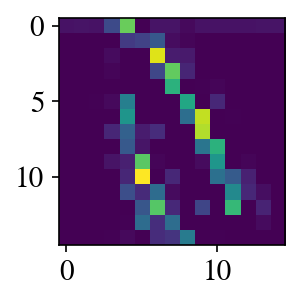

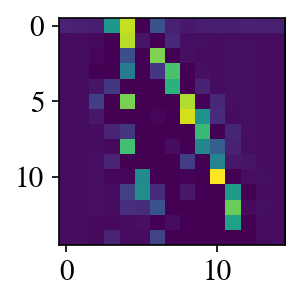

In [54]:
for i in range(4):
    figure=plt.figure(figsize=(2,2))
    plt.imshow(test_features[0][1,:,:,i])

In [56]:
inputs=Input((15,15,64))
x=inputs
x=Flatten()(x)
flattening=Model(inputs,x)
flatten_train=flattening.predict(train_features)
flatten_test=flattening.predict(test_features)

In [196]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(flatten_train,y_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [197]:
pred_rf=rf.predict(flatten_test)
accuracy_score(pred_rf,y_test_label)

0.64204545454545459

# From DenseLayers

In [101]:
inputs = [K.learning_phase()] + model2.inputs

_denseout_f = K.function(inputs, [denseout.output])
def denseout_f(X):
    # The [0] is to disable the training phase flag
    return _denseout_f([0] + [X])

In [114]:
test_features_dense=denseout_f(test_array)
train_features_dense1=denseout_f(train_array[0:500])
train_features_dense2=denseout_f(train_array[500:1000])
train_features_dense3=denseout_f(train_array[1000:1500])
train_features_dense4=denseout_f(train_array[1500:2000])
train_features_dense5=denseout_f(train_array[2000:])
train_features_dense=np.concatenate([train_features_dense1[0],train_features_dense2[0],train_features_dense3[0],train_features_dense4[0],train_features_dense5[0]],axis=0)
train_features_dense.shape

(2288, 256)

In [238]:
genelm=(GenELMClassifier(hidden_layer=MLPRandomLayer(n_hidden=1000,activation_func='tanh',biases=True,random_state=1)))
genelm.fit(train_features_dense,y_train_label)
pred_elm=genelm.predict(test_features_dense[0])
accuracy_score(pred_elm,y_test_label)

In [175]:
rf=(RandomForestClassifier(n_estimators=910,max_depth=None,max_features='sqrt'))
rf.fit(train_features_dense,y_train_label)
pred_rf=rf.predict(test_features_dense[0])
accuracy_score(pred_rf,y_test_label)

0.80113636363636365

In [170]:
lsvc=LinearSVC(C=5.0,penalty='l1',dual=False)
lsvc.fit(train_features_dense,y_train_label)
pred_lsvc=lsvc.predict(test_features_dense[0])
print ('test:',accuracy_score(pred_lsvc,y_test_label))
pred_train_lsvc=lsvc.predict(train_features_dense)
print ('train:',accuracy_score(pred_train_lsvc,y_train_label))

test: 0.679924242424
train: 1.0


In [156]:
model_class=Sequential()
model_class.add(Dense(512,input_shape=(256,))) # an extra layer added increased accuracy ,then batch norm was ot included in the model
model_class.add(Dropout(.6))
model_class.add(BatchNormalization())
model_class.add(Activation('relu'))

model_class.add(Dense(44))
#model_class.add(BatchNormalization())
model_class.add(Activation('softmax'))
adam=Adam(lr=.0001,beta_2=0.99,decay=1e-4)
model_class.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history_class=model_class.fit(train_features_dense,y_train,epochs=100,validation_data=(test_features_dense,y_test),batch_size=20, verbose= 1)

Train on 2288 samples, validate on 528 samples
Epoch 1/100
2288/2288 [==============================] - 3s 1ms/step - loss: 3.7440 - acc: 0.0695 - val_loss: 3.0174 - val_acc: 0.2765
Epoch 2/100
2288/2288 [==============================] - 1s 518us/step - loss: 2.9741 - acc: 0.2522 - val_loss: 2.5383 - val_acc: 0.4508
Epoch 3/100
2288/2288 [==============================] - 1s 479us/step - loss: 2.4037 - acc: 0.4314 - val_loss: 2.2116 - val_acc: 0.5568
Epoch 4/100
2288/2288 [==============================] - 1s 474us/step - loss: 1.9849 - acc: 0.5651 - val_loss: 1.9582 - val_acc: 0.6326
Epoch 5/100
2288/2288 [==============================] - 1s 493us/step - loss: 1.6553 - acc: 0.6766 - val_loss: 1.7749 - val_acc: 0.6648
Epoch 6/100
2288/2288 [==============================] - 2s 676us/step - loss: 1.3846 - acc: 0.7662 - val_loss: 1.6237 - val_acc: 0.6951
Epoch 7/100
2288/2288 [==============================] - 1s 480us/step - loss: 1.1877 - acc: 0.8077 - val_loss: 1.5049 - val_acc: 0.6

In [230]:
# def get_features(MODEL,width=128,data=X,batch_size=10):
#     cnn_model=MODEL(include_top=False,weights='imagenet',input_shape=(width,width,3))
#     inputs=Input((width,width,3))
#     x=inputs
#     x=Lambda(preprocess_input,name='preprocessing')(x)
#     x=vgg(x)
#     x=GlobalAveragePooling2D(x)
#     cnn_model=Model(inputs,x)
#     features=cnn_model.predict(data,verbose=1,batch_size=batch_size)
#     return features
# features_vgg=get_features(VGG16)
# inputs=Input((4,4,512))
# x=inputs
# x=Flatten()(x)
# flattening=Model(inputs,x)
# flatten_vgg=flattening.predict(features_vgg)

In [ ]:
# pred=model.predict(train_array)
# pred_test=model.predict(test_array)
# #print (decode_predictions(pred,top=3)[0])